In [1]:
#import libraries
import pandas as pd
import numpy as np
from datetime import datetime
import category_encoders as ce

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.preprocessing import LabelEncoder,StandardScaler,Normalizer
from sklearn.metrics import f1_score,r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer

import seaborn as sns
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

In [2]:
description = pd.read_csv('./scout_data/Data_Description.csv',sep=';')
description

,column name,description
0,article_id,unique article identifier
1,product_tier,premium status of the article
2,make_name,name of the car manufacturer
3,price,price of the article
4,first_zip_digit,first digit of the zip code of the region the ...
5,first_registration_year,year of the first registration of the article
6,created_date,creation date of the listing
7,deleted_date,deletion date of the listing
8,search_views,number of times the article has been shown as ...
9,detail_views,number of times the article has been clicked on


In [3]:
data = pd.read_csv('./scout_data/Case_Study_Data.csv',sep=';')
data.head()

,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr
0,350625839,Basic,Mitsubishi,16750,5,2013,24.07.18,24.08.18,3091.0,123.0,30,0.03780329990294403
1,354412280,Basic,Mercedes-Benz,35950,4,2015,16.08.18,07.10.18,3283.0,223.0,52,0.06792567773378008
2,349572992,Basic,Mercedes-Benz,11950,3,1998,16.07.18,05.09.18,3247.0,265.0,51,0.0816137973514013
3,350266763,Basic,Ford,1750,6,2003,20.07.18,29.10.18,1856.0,26.0,101,0.014008620689655173
4,355688985,Basic,Mercedes-Benz,26500,3,2014,28.08.18,08.09.18,490.0,20.0,12,0.04081632653061224


In [4]:
print('The data dataframe has {} data points'.format(data.shape[0]))

The data dataframe has 78321 data points


In [5]:
data.describe()

,article_id,price,first_zip_digit,first_registration_year,search_views,detail_views,stock_days
count,7.832100e+04,78321.000000,78321.000000,78321.000000,78311.000000,78311.000000,78321.000000
mean,3.574869e+08,15067.655316,4.632117,2011.089465,2297.502522,93.469870,35.986262
std,5.076572e+06,16374.497606,2.354275,6.538395,6339.034423,228.025588,32.214835
min,3.472324e+08,1.000000,1.000000,1924.000000,0.000000,0.000000,-3.000000
25%,3.536387e+08,5750.000000,3.000000,2008.000000,367.000000,13.000000,10.000000
50%,3.585480e+08,10900.000000,5.000000,2013.000000,920.000000,36.000000,25.000000
75%,3.614817e+08,18890.000000,7.000000,2015.000000,2234.000000,94.000000,55.000000
max,3.647040e+08,249888.000000,9.000000,2106.000000,608754.000000,13926.000000,127.000000


In [6]:
print('The most expensive car in the Dataset costs {} euros'.format(max(data['price'])))

The most expensive car in the Dataset costs 249888 euros


In [7]:
print('The least expensive car in the Dataset costs {} euros'.format(min(data['price'])))

The least expensive car in the Dataset costs 1 euros


#### Quick Comments
After a quick examination of the 'AS24_Case_Study_Data.csv'. I give a quick answer to the questions asked.
1. Is it possible to predict the product tier from the information given in the other columns? **Yes**
- This is a classification problem. The product tier column is in 3 categories: 'Basic', 'Plus', 'Premium'.
2. Is it possible to predict detail views from the information given in the other columns? **Yes**
- This is a regression problem.

Going forward, I will explore data and build basic pipeline to solve the problem.

In [8]:
data.head()

,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr
0,350625839,Basic,Mitsubishi,16750,5,2013,24.07.18,24.08.18,3091.0,123.0,30,0.03780329990294403
1,354412280,Basic,Mercedes-Benz,35950,4,2015,16.08.18,07.10.18,3283.0,223.0,52,0.06792567773378008
2,349572992,Basic,Mercedes-Benz,11950,3,1998,16.07.18,05.09.18,3247.0,265.0,51,0.0816137973514013
3,350266763,Basic,Ford,1750,6,2003,20.07.18,29.10.18,1856.0,26.0,101,0.014008620689655173
4,355688985,Basic,Mercedes-Benz,26500,3,2014,28.08.18,08.09.18,490.0,20.0,12,0.04081632653061224


#### Data Preparation & Cleaning

1. we convert 'created_date','deleted_date' to datetime to be able to extract the datetime details.
2. convert ctr column to float.

- **Deleted Rows**
1. All data points with first registration_year after 2022.
2. All live_days and stock_days less than zero.
3. All cars with prices less than 100.
4. All duplicated data points with duplicates 'article_id' and 'make_name'.
5. drop all rows containing non decimal like values or letters.


- **Feature Engineering: Created Columns**
1. live_days: The no of days between created_date and deleted_date.
2. first_registration_age: The no of years between the first registration year and this present year(2022).


**Notes:**  
For the model development, we drop the 'article_id','created_date','deleted_date' and 'first_registration_year'.

In [9]:
#convert created_date and deleted_date to datetime.
data[['created_date','deleted_date']] = data[['created_date','deleted_date']].apply(
    lambda _: pd.to_datetime(_,infer_datetime_format=True, errors='coerce'))

#create the live_days column.
data['live_days'] = (data['deleted_date'] - data['created_date']).dt.days

In [10]:
#drop all cars with first_registration_year of more than 2022
data = data[data['first_registration_year'] <= 2022]

#drop all columns with negative live days. (since you cannot have a listing deleted before it is created)
data = data[data['live_days'] >= 0]

#drop all negative stock days
data = data[data['stock_days'] >= 0]

#drop all cars with price less than 100 euros
data = data[data.price > 100]

In [11]:
#create registration age column to replace first_registration_year
data['first_registration_age'] = datetime.today().year - data['first_registration_year']

In [12]:
#check for repeated data points using article_id
data = data.drop_duplicates(subset=['article_id','make_name'])

In [13]:
#drop all rows containing non decimal like values or letters
data = data[data['ctr'].str.contains('\d+\.\d+\.\d+\.*|[a-zA-Z]',regex=True) == False]

#convert ctr to float

data['ctr'] = data['ctr'].astype(float)

#drop all null values from data

data.dropna(inplace=True)

In [14]:
#write the cleaned data to disk
#data.to_csv('./scout_data/cleaned_scout.csv',index=False)

In [15]:
#drop the article_id,'created_date','deleted_date' and first_registration_year

data.drop(['article_id','created_date','deleted_date','first_registration_year'],axis=1,inplace=True)

In [16]:
data = data.reset_index(drop=True)
data.head()

,product_tier,make_name,price,first_zip_digit,search_views,detail_views,stock_days,ctr,live_days,first_registration_age
0,Basic,Mitsubishi,16750,5,3091.0,123.0,30,0.037803,31,11
1,Basic,Ford,1750,6,1856.0,26.0,101,0.014009,101,21
2,Basic,Volkswagen,24890,6,125.0,6.0,2,0.048000,2,7
3,Basic,Fiat,2850,7,172.0,4.0,1,0.022093,31,16
4,Basic,Renault,23740,2,1499.0,99.0,87,0.062742,87,6


### Descriptive Analysis

Here, We want to explore the dataset, to understand the dataset better. We will make plots,create tables and a dashboard (using data google studio). Some plots created are:  
- Plot showing Mean ctr per product_tier.
- Plot showing Mean Price per product_tier.
- Heatmap showing column correlations.

Some tables created:
- the mean, minimum, maximum and standard deviation price per make_name.
- the mean, minimum, maximum and standard deviation price and ctr per first_zip_digit.
- mean,minimum and maximum price per age_bins

Note: The dashboard is available at: https://bit.ly/36HcgSA

In [17]:
data.describe()

,price,first_zip_digit,search_views,detail_views,stock_days,ctr,live_days,first_registration_age
count,54682.000000,54682.000000,54682.000000,54682.000000,54682.000000,54682.000000,54682.000000,54682.000000
mean,15199.511247,4.608646,2435.462072,98.848286,38.996690,0.048350,81.732618,12.895450
std,16403.226836,2.357797,6266.250369,219.018732,34.161531,0.390837,86.373135,6.616951
min,101.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,4.000000
25%,5850.000000,3.000000,375.000000,13.000000,9.000000,0.024160,19.000000,9.000000
50%,10950.000000,5.000000,984.000000,39.000000,30.000000,0.037621,56.000000,11.000000
75%,18900.000000,7.000000,2465.000000,102.000000,62.000000,0.057471,117.000000,16.000000
max,249888.000000,9.000000,608754.000000,12286.000000,127.000000,87.500000,600.000000,100.000000


In [18]:
## What is the mean, minimum, maximum and standard deviation price per make_name
data.groupby(['make_name']).agg({'price': [np.mean, np.max, np.min, np.std, 'count']}).reset_index().head(10)

make_name          price                                    
                          mean    amax    amin           std count
0            AC  139900.000000  139900  139900           NaN     1
1        Abarth   22868.666667   40540    7350   9833.866313    15
2         Aixam    7953.166667   20019    1200   4818.020295    18
3    Alfa Romeo   13667.783290  115000     375  16245.994395   383
4        Alpina   31397.500000   59950   13995  15670.590847     6
5        Alpine   80245.000000   82500   77990   3189.051583     2
6      Amphicar   52500.000000   52500   52500           NaN     1
7  Aston Martin   88765.473684  185000   29000  50934.693468    19
8          Audi   24128.993197  160602     300  21342.718192  2352
9        Austin   76537.500000  125000   10000  47313.617415     8

In [19]:
df = data.copy()

#create 5 bins over carat
df['age_bins'] = pd.cut(df['first_registration_age'],bins=8)

#calculate mean, max,min and std over each bin
df.groupby(['age_bins']).agg({'price': [np.mean, np.max, np.min, np.std, 'count']}).reset_index()

age_bins         price                                    
                          mean    amax   amin           std  count
0  (3.904, 16.0]  17969.983946  249888    101  16614.088595  42294
1   (16.0, 28.0]   4414.341101  146900    111   6648.169102  11586
2   (28.0, 40.0]  14218.454545  209950    350  21269.763919    341
3   (40.0, 52.0]  20469.487923  149500   1449  21873.160413    207
4   (52.0, 64.0]  36402.197802  175000   1150  30115.698625    182
5   (64.0, 76.0]  60462.105263  182500   6750  52932.252143     57
6   (76.0, 88.0]  49111.111111  149950  14000  45336.545536      9
7  (88.0, 100.0]  62233.333333  235000  13000  85111.607121      6

In [20]:
## What is the mean, minimum, maximum and standard deviation price per first_zip_digit
data.groupby(['first_zip_digit']).agg({'price': [np.mean, np.max, np.std,'count']}).reset_index()

first_zip_digit         price                            
                           mean    amax           std count
0               1  17626.309318  239800  19300.477677  5441
1               2  15014.892517  185000  14176.577241  6922
2               3  14808.774214  209750  16294.219232  9354
3               4  15045.534504  199950  14953.746083  4782
4               5  15265.757619  249888  17041.305628  8499
5               6  16558.660233  248341  19483.482116  4974
6               7  14263.352529  235000  15760.859257  7415
7               8  14654.543996  201717  15045.873014  4364
8               9  13309.853292  160602  13020.536786  2931

In [21]:
## What is the mean, minimum, maximum and standard deviation ctr per first_zip_digit
data.groupby(['first_zip_digit']).agg({'ctr': [np.mean, np.max, np.std,'count']}).reset_index()

first_zip_digit       ctr                           
                       mean       amax       std count
0               1  0.044803   0.790123  0.038285  5441
1               2  0.043429   0.875000  0.035877  6922
2               3  0.055449  87.500000  0.905103  9354
3               4  0.052450  25.000000  0.362956  4782
4               5  0.047563   0.631579  0.037132  8499
5               6  0.045790   0.772727  0.037612  4974
6               7  0.048510   0.833333  0.042464  7415
7               8  0.048237   0.841667  0.041860  4364
8               9  0.043613   0.461942  0.033377  2931

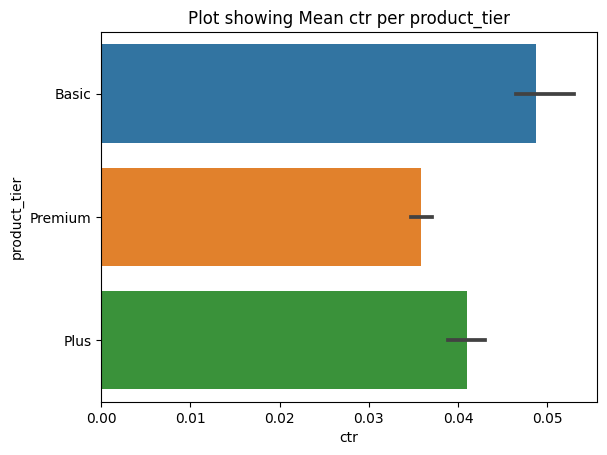

In [22]:
#mean ctr per product_tier

fig = sns.barplot(data=data,x = 'ctr', y = 'product_tier',orient='h')
plt.title('Plot showing Mean ctr per product_tier')
plt.show()

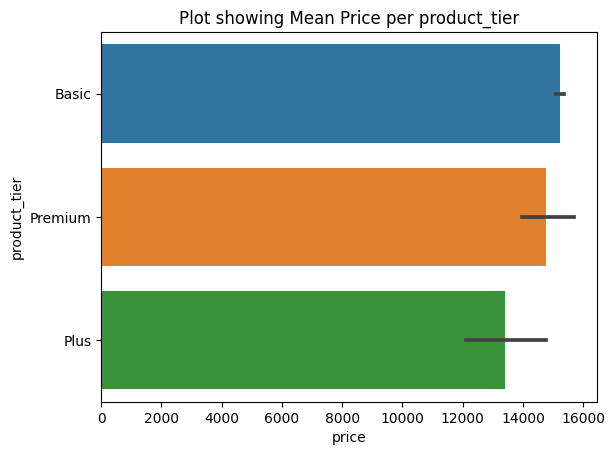

In [23]:
#mean price per product_tier

fig = sns.barplot(data=data,x = 'price', y = 'product_tier',orient='h')
plt.title('Plot showing Mean Price per product_tier')
plt.show()

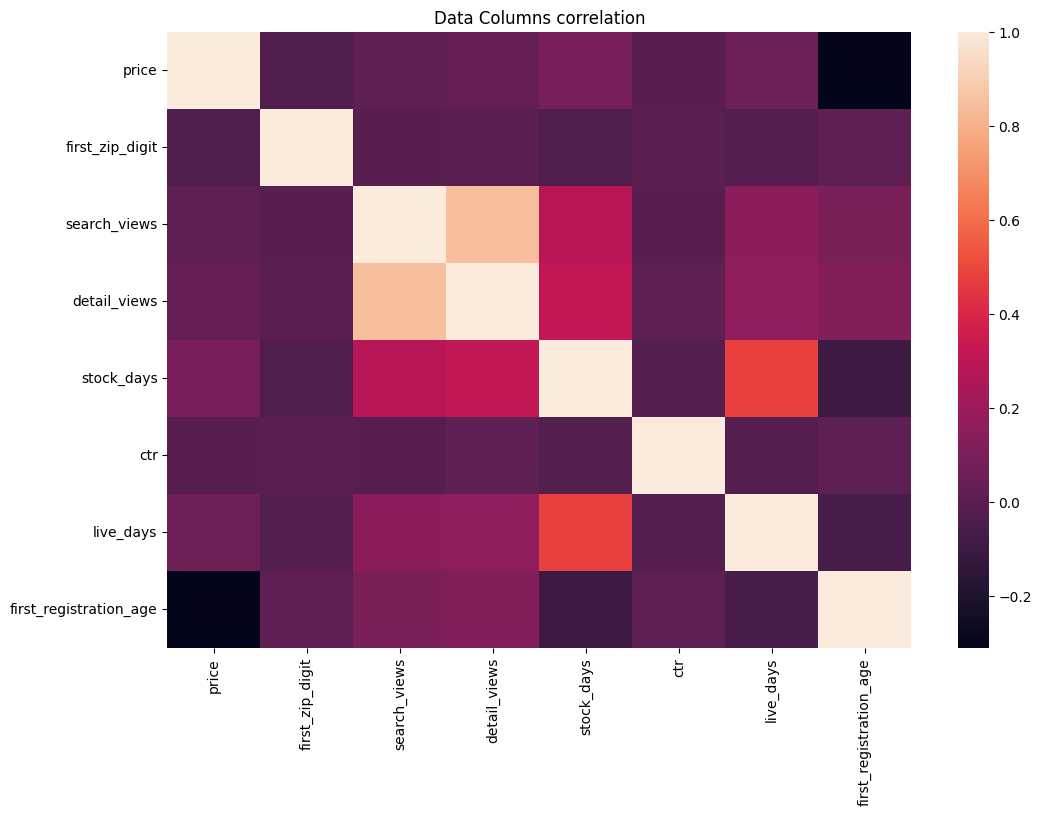

In [24]:
#plot data-column correlations

plt.figure(figsize=(12,8))
plt.title('Data Columns correlation')
sns.heatmap(data.corr())
plt.show()

More visualizations/Dashboard can be seen at: https://bit.ly/36HcgSA

#### Notes: Model Development 1 & 2
- In Model Development 1, we build a classification model to predict a product tier. Our Approach is to build first, a logistic regression (serves as a **baseline model**) and a gradient boosted trees classifier.

In Model development 1, we encode the 'make name' of the cars in the data using the **base Encoder.** while normalize the 'price' and 'first_registration_age' columns.

- In Model Development 2, we build a regression model to predict the number of detail views. Here as well we build a linear regression pipeline (**baseline pipeline**) and a random forest regression model.

For the regression pipeline, we one-hot encode the product-tier column, while we base encode the 'make name' columns of the cars. Using column transformer, we also normalize the 'price' and 'first_registration_age' columns.

### Model Development 1

In [27]:
#split the data into X and y
y = data.product_tier
X = data.drop('product_tier',axis=1)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [28]:
#encode the target variable

le = LabelEncoder() 
y_train = le.fit_transform(y_train)

In [29]:
#test the label encode
le.inverse_transform([0,1,2])

array(['Basic', 'Plus', 'Premium'], dtype=object)

In [30]:
data.head()

,product_tier,make_name,price,first_zip_digit,search_views,detail_views,stock_days,ctr,live_days,first_registration_age
0,Basic,Mitsubishi,16750,5,3091.0,123.0,30,0.037803,31,11
1,Basic,Ford,1750,6,1856.0,26.0,101,0.014009,101,21
2,Basic,Volkswagen,24890,6,125.0,6.0,2,0.048000,2,7
3,Basic,Fiat,2850,7,172.0,4.0,1,0.022093,31,16
4,Basic,Renault,23740,2,1499.0,99.0,87,0.062742,87,6


In [31]:
#set up the column transfomer
ct = ColumnTransformer([
        ('transformer', Normalizer(norm='l1'), ['price','first_registration_age'])
    ], remainder='passthrough')

##### Logistic Regression

In [32]:
#instantiate encoders
ce_base = ce.BaseNEncoder(cols=['make_name'],base=5)

#Build pipeline
pipe_lr = Pipeline([('encoder', ce_base),
                    ('transformer', ct),
                    ('logistic', LogisticRegression(solver='liblinear'))])

#fit the pipeline
pipe_lr.fit(X_train,y_train)

#make predictions
preds = pipe_lr.predict(X_test)

In [33]:
#transform y_test
y_test = le.transform(y_test)

#Test model accuracy with f1_score
f1_score(y_test, preds, average='macro')

0.42424702421693544

##### Extra Trees

In [35]:
from sklearn.ensemble import ExtraTreesClassifier

ext = ExtraTreesClassifier(n_estimators=300, random_state=42)

#Build pipeline
pipe_ext = Pipeline([('encoder', ce_base),
                    ('transformer', ct),
                    ('extra trees', ext)])

#fit the pipeline
pipe_ext.fit(X_train,y_train)

#make predictions
preds_ext = pipe_ext.predict(X_test)

In [36]:
#Test model accuracy with f1_score
f1_score(y_test, preds_ext, average='macro')

0.48445828280628356

### Model Development 2

In [34]:
#set up the column transfomer
ct = ColumnTransformer([
        ('transformer', Normalizer(norm='l1'), ['price','first_registration_age'])
    ], remainder='passthrough')

In [35]:
#split the data into X and y
y = data.detail_views
X = data.drop('detail_views',axis=1)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

##### Linear Regression

In [36]:
#instantiate encoders
ce_base = ce.BaseNEncoder(cols=['make_name'],base=5)

ce_one = ce.OneHotEncoder(cols=['product_tier']) 

#Build pipeline
pipe_lc = Pipeline([('base_encoder', ce_base), 
                    ('one_hot',ce_one), 
                    ('transformer', ct),
                    ('linear', LinearRegression())])

#fit the pipeline
pipe_lc.fit(X_train,y_train)

#make predictions
preds_lc = pipe_lc.predict(X_test)

In [37]:
#test model accuracy
r2_score(y_test, preds_lc)

0.7392265133160694

##### Random Forest

In [38]:
rf = RandomForestRegressor(max_depth=4, random_state=42, n_estimators=300)

#Build pipeline
pipe_rf = Pipeline([('base_encoder', ce_base),
                    ('one_hot',ce_one),
                    ('transformer', ct),
                    ('Random Forest', rf)])

#fit the pipeline
pipe_rf.fit(X_train,y_train)

#make predictions
preds_rf = pipe_rf.predict(X_test)

In [39]:
#test model accuracy
r2_score(y_test, preds_rf)

0.858028197316756